In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import json


In [0]:
data_path =  '/content/gdrive/My Drive/Colab Notebooks/fr2phonetics/final_prononciation.txt'
with open(data_path, 'r', encoding='UTF8') as text_file:
    print('Reading file')
    txt = text_file.read().split('\n')

txt=np.random.permutation(txt)
train_valid_data = txt[:int(len(txt)*.9)]
test_data = txt[int(len(txt)*.9):]

train_data = train_valid_data

input_chars = []
target_chars = []

def getDataFromArray(arr):
  x = []
  y = []
  for line in arr:
    data = line.split("####")
    input_txt = data[0]
    target_txt = '\t'+data[1]+'\n'

    x.append(input_txt)
    y.append(target_txt)

    for char in input_txt:
      if char not in input_chars:
        input_chars.append(char)
    if ' ' not in input_chars:
      input_chars.append(' ')
      
    for char in target_txt:
      if char not in target_chars:
        target_chars.append(char)
    if ' ' not in target_chars:
      target_chars.append(' ')
    if '\n' not in target_chars:
      target_chars.append('\n')
    if '\t' not in target_chars:
      target_chars.append('\t')

  return x,y

In [0]:
x_train,y_train = getDataFromArray(train_data)
x_test,y_test = getDataFromArray(test_data)

In [0]:
def encodeData(x,y):
  encoder_input_data = np.zeros((len(x), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
  decoder_input_data = np.zeros((len(x), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
  decoder_target_data = np.zeros((len(x), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

  for i, (input_text, target_text) in enumerate(zip(x, y)):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t, input_token_index[char]] = 1.
      encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
      for t, char in enumerate(target_text):
          decoder_input_data[i, t, target_token_index[char]] = 1.
          if t > 0:
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.
      decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
      decoder_target_data[i, t:, target_token_index[' ']] = 1.
      if(i%1000==0):
        print('{} sentences retrieved'.format(i+1))

  return encoder_input_data, decoder_input_data, decoder_target_data

def encodeText(x):
  encoder_input_data = np.zeros((len(x), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
  for i, input_text in enumerate(x):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t, input_token_index[char]] = 1.
      encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.  
  return encoder_input_data

In [0]:
encoder_train_input_data, decoder_train_input_data, decoder_train_target_data = encodeData(x_train,y_train)

1 sentences retrieved
1001 sentences retrieved
2001 sentences retrieved
3001 sentences retrieved
4001 sentences retrieved
5001 sentences retrieved
6001 sentences retrieved
7001 sentences retrieved
8001 sentences retrieved
9001 sentences retrieved
10001 sentences retrieved
11001 sentences retrieved
12001 sentences retrieved
13001 sentences retrieved
14001 sentences retrieved
15001 sentences retrieved
16001 sentences retrieved
17001 sentences retrieved
18001 sentences retrieved
19001 sentences retrieved
20001 sentences retrieved
21001 sentences retrieved
22001 sentences retrieved
23001 sentences retrieved
24001 sentences retrieved
25001 sentences retrieved
26001 sentences retrieved
27001 sentences retrieved
28001 sentences retrieved
29001 sentences retrieved
30001 sentences retrieved
31001 sentences retrieved
32001 sentences retrieved
33001 sentences retrieved
34001 sentences retrieved
35001 sentences retrieved
36001 sentences retrieved
37001 sentences retrieved
38001 sentences retrieved

marloise


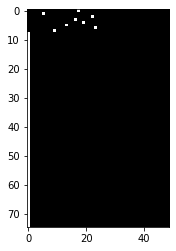

maʁ.lwaz


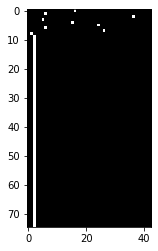

titi


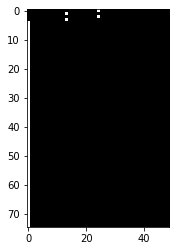

ti.ti


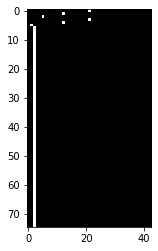

verrerie


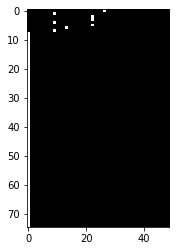

vɛʁ.ʁi


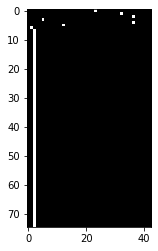

vaincu


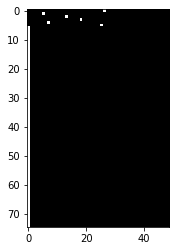

vɛ̃.ky


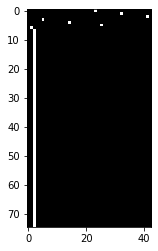

tuit


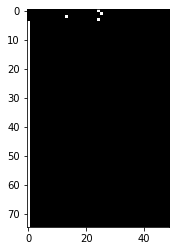

tɥit


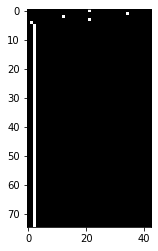

In [0]:
# !pip install matplotlib

import matplotlib.pyplot as plt
from PIL import Image

def showWordMatrix(matrix):
  data, _, _ = encodeData(word,[' '])
  plt.imshow(matrix*255, cmap='gray', vmin=0, vmax=255)
  plt.show()

for i in range(5):
  print(x_train[i])
  plt.imshow(encoder_train_input_data[i]*255, cmap='gray', vmin=0, vmax=255)
  plt.show()
  print(y_train[i][1:-1])
  plt.imshow(decoder_train_target_data[i]*255, cmap='gray', vmin=0, vmax=255)
  plt.show()


In [0]:

# encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_inputs')
encoder = Bidirectional(LSTM(latent_dim, return_state=True), name='encoder_bidirectionnal_lstm')
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')    
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary(line_length = 250)


Model: "model_64"
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                      Output Shape                                           Param #                       Connected to                                                                       
encoder_inputs (InputLayer)                                                       [(None, None, 49)]                                     0                                                                                                                
_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [0]:
model = load_model("/content/gdrive/My Drive/Colab Notebooks/fr2phonetics/bidirectionnal_seq2seq_phonetics_fr.h5")
model.fit(
    [encoder_train_input_data, decoder_train_input_data], decoder_train_target_data,
    batch_size=batch_size,
    epochs=5,
    shuffle=True,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss')],
    validation_split=0.1,
)
model.save("/content/gdrive/My Drive/Colab Notebooks/fr2phonetics/bidirectionnal_seq2seq_phonetics_fr.h5")

In [0]:
encoder_inputs = model.inputs[0]   # input_1
encoder_outputs, forward_h, forward_c, backward_h, backward_c = model.layers[1].output   # lstm_1
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.inputs[1]   # input_2
decoder_state_input_h = Input(shape=(latent_dim*2,), name='input_3')
decoder_state_input_c = Input(shape=(latent_dim*2,), name='input_4')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[-1]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [0]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [0]:
encoder_test_input_data, decoder_test_input_data, decoder_test_target_data = encodeData(x_test,y_test)

1 sentences retrieved
1001 sentences retrieved
2001 sentences retrieved
3001 sentences retrieved
4001 sentences retrieved
5001 sentences retrieved
6001 sentences retrieved
7001 sentences retrieved
8001 sentences retrieved
9001 sentences retrieved
10001 sentences retrieved
11001 sentences retrieved
12001 sentences retrieved
13001 sentences retrieved
14001 sentences retrieved
15001 sentences retrieved
16001 sentences retrieved


In [0]:
# !pip install nltk
import nltk

similiScores = 0
BLEUscore = []

for seq_index in range(len(encoder_test_input_data)):
    input_seq = encoder_test_input_data[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print()
    print('Data #{} / {}'.format(seq_index,len(encoder_test_input_data)-1))
    print("input sentence : {}".format(x_test[seq_index]))
    print("expected decoded sentence : {}".format(y_test[seq_index][1:-1]))
    print("real decoded sentence : {}".format(decoded_sentence[:-1]))
    
    BLEUscore.append(nltk.translate.bleu_score.sentence_bleu([list(y_test[seq_index][1:-1])], list(decoded_sentence[:-1])))
    if list(y_test[seq_index][1:-1]) == list(decoded_sentence[:-1]):
      similiScores += 1
    print(similiScores/(seq_index+1))

similiScores /= len(encoder_test_input_data)
BLEUscore = sum(BLEUscore) / len(BLEUscore)

print('BLEU score : {}'.format(BLEUscore))
print('similarity score : {}'.format(similiScores))

Output hidden; open in https://colab.research.google.com to view.